In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings

In [2]:
class1_cats = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
class2_cats = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
both_class = class1_cats+class2_cats

newsgroups_train = fetch_20newsgroups(subset='train', categories=both_class)

list(newsgroups_train.target_names)

['comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey']

In [3]:
targets = newsgroups_train.target_names
print(targets)
label_to_ind_map = {label:i for i,label in enumerate(targets)}
ind_to_label_map = {i:label for i,label in enumerate(targets)}

['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']


In [4]:
labels = newsgroups_train.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
print (f"There are {category_sizes} number of each categories")

There are [584 591 590 578 594 598 597 600] number of each categories


## Generate sparse TF-IDF representations
### Question 1:

In [5]:
count_vect = CountVectorizer(min_df=3, stop_words='english')
X_counts = count_vect.fit_transform(newsgroups_train.data)

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print('Dimension of the TF-IDF matrix:', X_tfidf.shape)

Dimension of the TF-IDF matrix: (4732, 20297)


## Clustering
### K-means

In [6]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=2,
    max_iter=1000,
    n_init=30,
    random_state=0,
).fit(X_tfidf)
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
print(f"Number of elements assigned to each cluster: {cluster_sizes}")
print()
print(
"True number of documents in each category according to the class labels: "
f"{category_sizes}"
)

Number of elements assigned to each cluster: [3719 1013]

True number of documents in each category according to the class labels: [584 591 590 578 594 598 597 600]


In [7]:
targets = newsgroups_train.target
labels_true = [0 if target<4 else 1 for target in targets]

### QUESTION 2: 
- <font size="4"> Report the contingency table of your clustering result. You may use the provided plotmat.py to visualize the matrix. Does the contingency matrix have to be square-shaped?

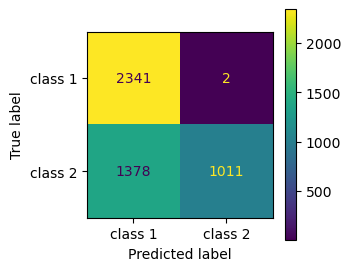

In [8]:
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import ConfusionMatrixDisplay

labels_pred = kmeans.labels_
cm = contingency_matrix(labels_true, labels_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['class 1', 'class 2'])
disp.plot()
fig = plt.gcf()
fig.set_size_inches(3,3)

Since we have selected k=2 and we are trying to cluster a dataset consisting of two classes, the contingency matrix is expected to be square-shaped.

The clustering performs poorly by assigning incorrectly class 1 to 1378 of class 2 examples.


In [9]:
from collections import defaultdict
from time import time

from sklearn import metrics

evaluations = []
evaluations_std = []


def evaluate(km, print_scores = False):
    scores = defaultdict(list)
    scores["Homogeneity"].append(metrics.homogeneity_score(labels_true, km.labels_))
    scores["Completeness"].append(metrics.completeness_score(labels_true, km.labels_))
    scores["V-measure"].append(metrics.v_measure_score(labels_true, km.labels_))
    scores["Adjusted Rand-Index"].append(
        metrics.adjusted_rand_score(labels_true, km.labels_)
    )
    scores["Adjusted mutual information score"].append(
        metrics.adjusted_mutual_info_score(labels_true, km.labels_)
    )
    score_list = [scores["Homogeneity"], scores["Completeness"], scores["V-measure"]
                 ,scores["Adjusted Rand-Index"], scores["Adjusted mutual information score"]]
    if print_scores:
        for score_name, score_values in scores.items():
            print (f"{score_name}: {score_values[0]}")
    
    return score_list
        

### QUESTION 3: 
<font size="4"> Report the 5 clustering measures explained in the introduction for K- means clustering.

In [10]:
evaluate(kmeans, print_scores = True)

Homogeneity: 0.24806575874532288
Completeness: 0.3310854241426923
V-measure: 0.28362527566607726
Adjusted Rand-Index: 0.17352672307883177
Adjusted mutual information score: 0.2835003215465688


[[0.24806575874532288],
 [0.3310854241426923],
 [0.28362527566607726],
 [0.17352672307883177],
 [0.2835003215465688]]

## Clustering with Dense Text Representations
### Generate dense representations for better K-Means Clustering
### QUESTION 4

<font size="4"> Report the plot of the percentage of variance that the top r principle components retain v.s. r, for r = 1 to 1000.

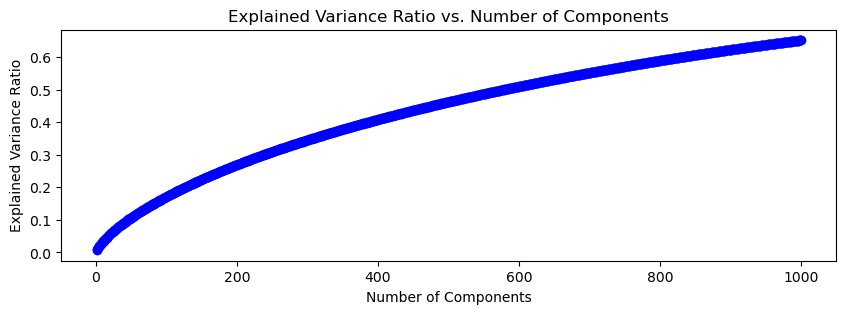

In [11]:
from sklearn.decomposition import TruncatedSVD, NMF

exp_var = []
svd_full = TruncatedSVD(n_components=1001)
svd_full.fit(X_tfidf)

# Calculate cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(svd_full.explained_variance_ratio_)

# Define range of smaller n_components
n_components = range(1, 1001)

# Calculate explained variance for smaller n_components 
explained_variance_ratio = cumulative_explained_variance_ratio[n_components]

# Plot the Explained Variance Ratio vs. Number of Components
plt.figure(figsize=(10, 3))
plt.plot(n_components, explained_variance_ratio, marker='o', linestyle='-', color='b')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
# plt.grid(True)
plt.show()

### QUESTION 5:
- <font size="4"> Let r be the dimension that we want to reduce the data to (i.e. n components).
Try r = 1 − 10, 20, 50, 100, 300, and plot the 5 measure scores v.s. r for both SVD
and NMF.
Report a good choice of r for SVD and NMF respectively.
     

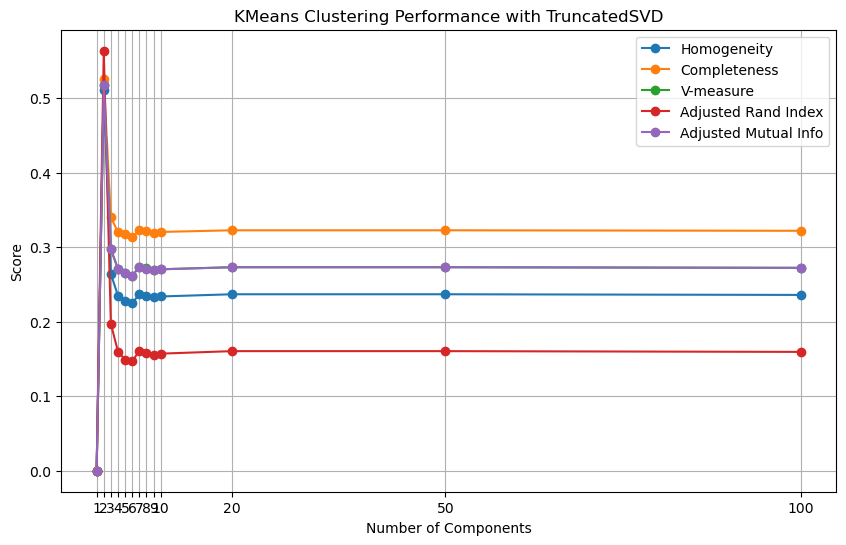

In [12]:
# SVD
r = list(range(1,11))+[20, 50, 100]
homogeneity = []
completeness = []
v_measure = []
adj_rand_ind = []
adj_mutual_info = []

for n_components in r:
    svd = TruncatedSVD(n_components=n_components, random_state=0)
    X_reduced = svd.fit_transform(X_tfidf)
    
    # perform clustering
    kmeans = KMeans(
    n_clusters=2,
    max_iter=1000,
    n_init=30,
    random_state=0,
    ).fit(X_reduced)
    
    # evaluate
    scores = evaluate(kmeans)
    homogeneity.append(scores[0])
    completeness.append(scores[1])
    v_measure.append(scores[2])
    adj_rand_ind.append(scores[3])
    adj_mutual_info.append(scores[4])
    
# Plot evaluation scores for each metric
def plot_scores(r, scores, title, score_names):
    plt.figure(figsize=(10, 6))
    for score, score_name in zip(scores, score_names):
        plt.plot(r, score, marker='o', label=score_name)
    plt.title(title)
    plt.xlabel('Number of Components')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.xticks(r, [str(int(num)) for num in r])  # Convert numbers to integers for tick labels
    plt.show()

scores = [homogeneity, completeness, v_measure, adj_rand_ind, adj_mutual_info]
score_names = ['Homogeneity', 'Completeness', 'V-measure', 'Adjusted Rand Index', 'Adjusted Mutual Info']

plot_scores(r, scores, 'KMeans Clustering Performance with TruncatedSVD', score_names)

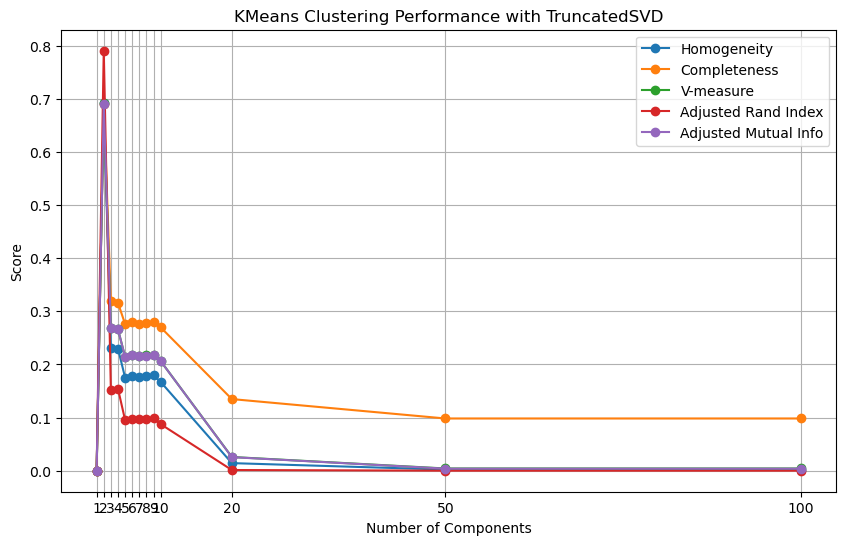

In [13]:
# NMF
r = list(range(1,11))+[20, 50, 100]
homogeneity = []
completeness = []
v_measure = []
adj_rand_ind = []
adj_mutual_info = []

for n_components in r:
    nmf = NMF(n_components=n_components, random_state=0)
    X_reduced = nmf.fit_transform(X_tfidf)
    
    # perform clustering
    kmeans = KMeans(
    n_clusters=2,
    max_iter=1000,
    n_init=30,
    random_state=0,
    ).fit(X_reduced)
    
    # evaluate
    scores = evaluate(kmeans)
    homogeneity.append(scores[0])
    completeness.append(scores[1])
    v_measure.append(scores[2])
    adj_rand_ind.append(scores[3])
    adj_mutual_info.append(scores[4])
    
# Plot evaluation scores for each metric
def plot_scores(r, scores, title, score_names):
    plt.figure(figsize=(10, 6))
    for score, score_name in zip(scores, score_names):
        plt.plot(r, score, marker='o', label=score_name)
    plt.title(title)
    plt.xlabel('Number of Components')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.xticks(r, [str(int(num)) for num in r])  # Convert numbers to integers for tick labels
    plt.show()

scores = [homogeneity, completeness, v_measure, adj_rand_ind, adj_mutual_info]
score_names = ['Homogeneity', 'Completeness', 'V-measure', 'Adjusted Rand Index', 'Adjusted Mutual Info']

plot_scores(r, scores, 'KMeans Clustering Performance with TruncatedSVD', score_names)

For both SVD and NMF, reducing the dimension to two most informative ones lead to the best performance of the Kmeans clustering algorithm.

### QUESTION 6:

- <font size ="4"> How do you explain the non-monotonic behavior of the measures as r increases?

High-dimensional data, especially when represented by sparse vectors like TF-IDF, is susceptible to the curse of dimensionality. In high-dimensional spaces, data points tend to become more spread out, and the concept of distance between points loses its meaning. Clustering algorithms that rely on distance metrics (e.g., KMeans) can struggle to effectively partition data points into meaningful clusters in such high-dimensional spaces. Because of this, as the retained number of components go beyond 2 (increase in r), the performance becomes worse due to the curse of dimensionality. However, one should note that there is a trade-off between the information preservation, and better performance of k-means in lower dimensions. Accordingly, just 1 component does not carry significant information in comparison to 2 components.     
    
### QUESTION 7:
- <font size ="4"> Are these measures on average better than those computed in Question 3?

Yes, with just 2 components retained, the measures has increased to above 0.5 and 0.65 for SVD and NMF, respectively.
    
## Visualize the clusters
    
### QUESTION 8: 
Visualize the clustering results for:
• SVD with your optimal choice of r for K-Means clustering;
• NMF with your choice of r for K-Means clustering.

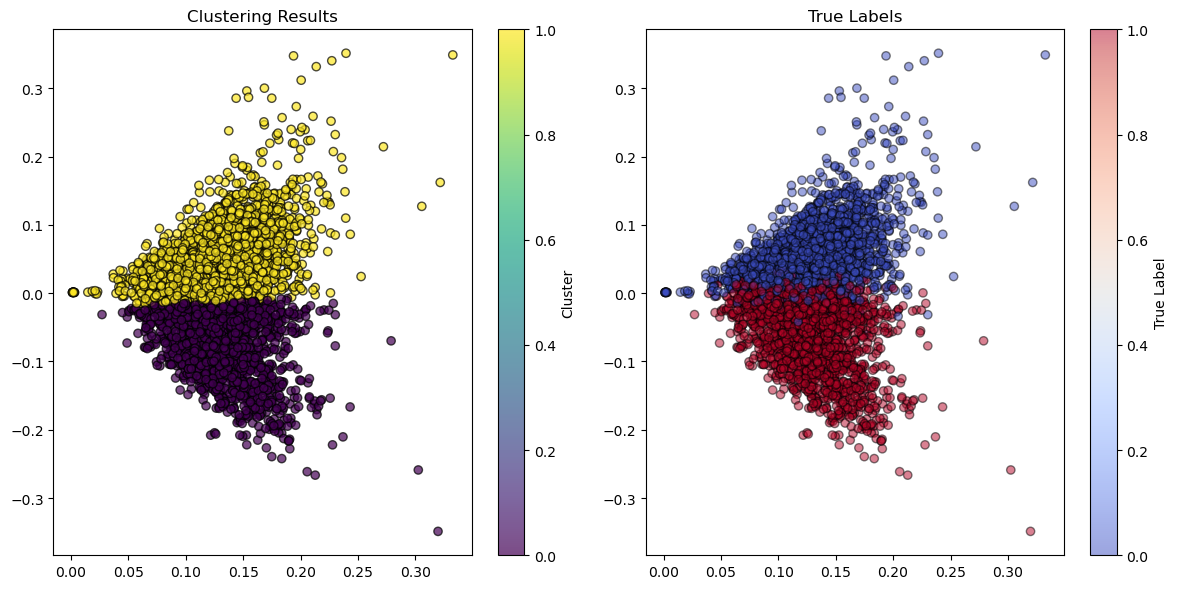

In [14]:
#SVD
svd = TruncatedSVD(n_components=2, random_state=0)
X_2d = svd.fit_transform(X_tfidf)

# perform clustering
kmeans = KMeans(
n_clusters=2,
max_iter=1000,
n_init=30,
random_state=0,
).fit(X_2d)
    

labels = kmeans.labels_


plt.figure(figsize=(12, 6))

# Plot clustered points
plt.subplot(1, 2, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis', alpha=0.7, edgecolors='k', label='Clustered Labels')
plt.colorbar(label='Cluster')
plt.title('Clustering Results')

# Plot true labels
plt.subplot(1, 2, 2)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_true, cmap='coolwarm', alpha=0.5, edgecolors='k', label='True Labels')
plt.colorbar(label='True Label')
plt.title('True Labels')

plt.tight_layout()
plt.show()

In [116]:
ind = labels_true[:10]==1
print(type(labels_true))

<class 'list'>


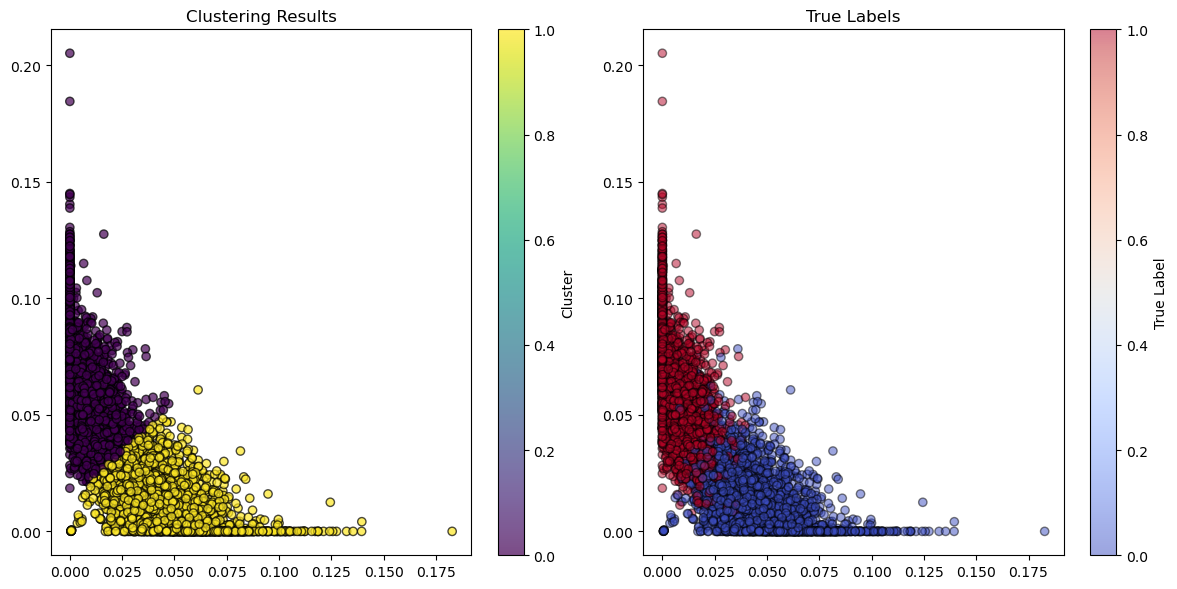

In [15]:
#SVD
nmf = NMF(n_components=2, random_state=0)
X_2d = nmf.fit_transform(X_tfidf)

# perform clustering
kmeans = KMeans(
n_clusters=2,
max_iter=1000,
n_init=30,
random_state=0,
).fit(X_2d)
    

labels = kmeans.labels_

plt.figure(figsize=(12, 6))

# Plot clustered points
plt.subplot(1, 2, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis', alpha=0.7, edgecolors='k', label='Clustered Labels')
plt.colorbar(label='Cluster')
plt.title('Clustering Results')

# Plot true labels
plt.subplot(1, 2, 2)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_true, cmap='coolwarm', alpha=0.5, edgecolors='k', label='True Labels')
plt.colorbar(label='True Label')
plt.title('True Labels')

plt.tight_layout()
plt.show()

### QUESTION 9: 
<font size="4"> What do you observe in the visualization? How are the data points of the two classes distributed? Is distribution of the data ideal for K-Means clustering?

Although the clustering performance has been improved following the reduction of dimension, there is still some examples which are incorrectly clustered using Kmeans method. The reason is that k-means consists of minimizing sample’s euclidean distances to the centroid of the cluster they are assigned to and as a consequence, k-means is more appropriate for clusters that are isotropic and normally distributed (i.e. spherical gaussians). But, as it can be seen in the above plots, clusters based on true labels are not forming an isotropic shape.
    
## Clustering of the Entire 20 Classes
### QUESTION 10
##### SVD

Dimension of the TF-IDF matrix: (11314, 38563)
Report five clustering metrics when SVD is used befor clustering the 20 classes:
Homogeneity: 0.3446637504634806
Completeness: 0.38950412463883594
V-measure: 0.3657145919121205
Adjusted Rand-Index: 0.13616913740626882
Adjusted mutual information score: 0.36203891842203473


[[0.3446637504634806],
 [0.38950412463883594],
 [0.3657145919121205],
 [0.13616913740626882],
 [0.36203891842203473]]

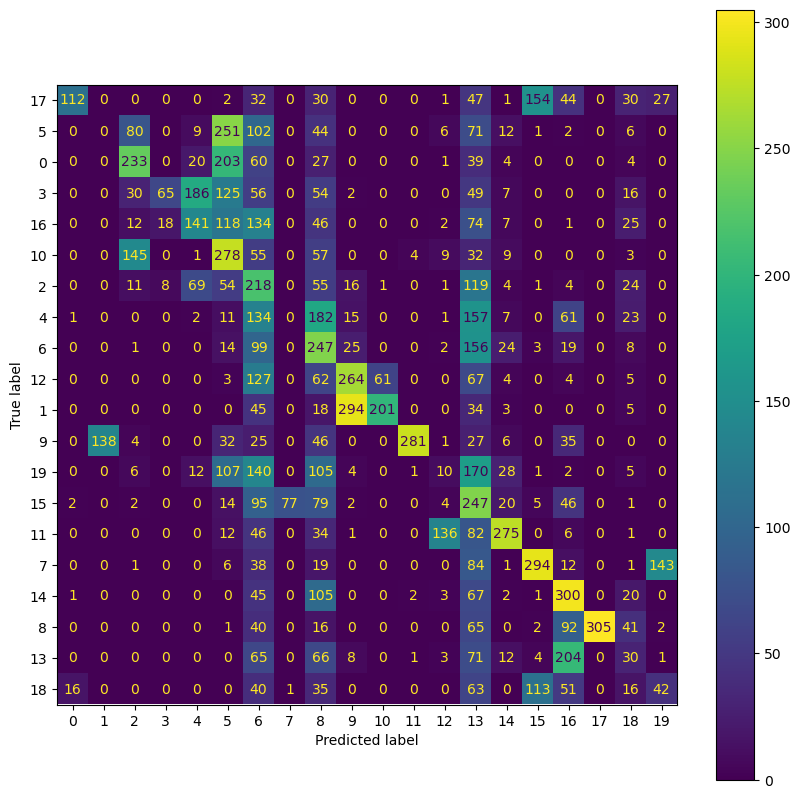

In [16]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

newsgroups_train_all = fetch_20newsgroups(subset='train')
labels_true = newsgroups_train_all.target
count_vect = CountVectorizer(min_df=3, stop_words='english')
X_counts = count_vect.fit_transform(newsgroups_train_all.data)

tfidf_transformer = TfidfTransformer()
X_tfidf_all = tfidf_transformer.fit_transform(X_counts)
print('Dimension of the TF-IDF matrix:', X_tfidf_all.shape)

n_components = 10
svd = TruncatedSVD(n_components=n_components, random_state=0)
X_reduced = svd.fit_transform(X_tfidf_all)

# perform clustering
kmeans = KMeans(
n_clusters=20,
max_iter=1000,
n_init=30,
random_state=0,
).fit(X_reduced)

# plot contingency matrix
labels_pred = kmeans.labels_

cm = confusion_matrix(labels_true, labels_pred)
rows, cols = linear_sum_assignment(cm, maximize=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm[rows[:, np.newaxis], cols])
disp.plot()
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(10,10)
ax.set_xticklabels(rows)
ax.set_yticklabels(cols)


# print the five clustering metrics for SVD
print ('Report five clustering metrics when SVD is used befor clustering the 20 classes:')
evaluate(kmeans, print_scores = True)

##### NMF

Report five clustering metrics when NMF is used befor clustering the 20 classes:

Homogeneity: 0.3083681513559579
Completeness: 0.338083152072363
V-measure: 0.3225427067940302
Adjusted Rand-Index: 0.1132832415724827
Adjusted mutual information score: 0.3186643220676152


[[0.3083681513559579],
 [0.338083152072363],
 [0.3225427067940302],
 [0.1132832415724827],
 [0.3186643220676152]]

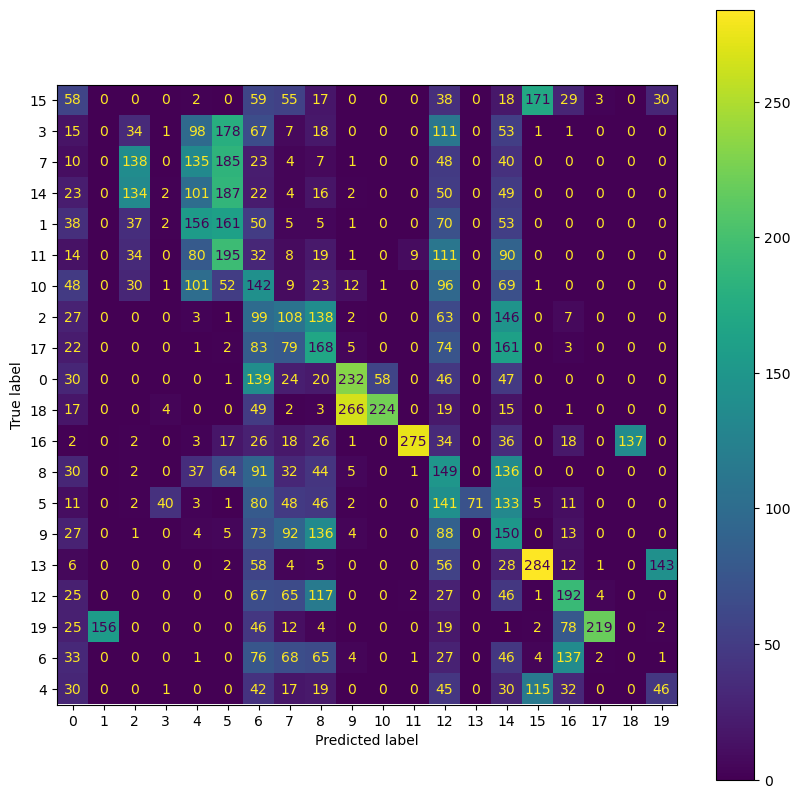

In [17]:
# reduce dimension using NMF and ratain 2 most informative ones
n_components = 8
nmf = NMF(n_components=n_components, random_state=0)
X_reduced = nmf.fit_transform(X_tfidf_all)

# perform clustering
kmeans = KMeans(
n_clusters=20,
max_iter=1000,
n_init=30,
random_state=0,
).fit(X_reduced)

# plot contingency matrix
labels_pred = kmeans.labels_

cm = confusion_matrix(labels_true, labels_pred)
rows, cols = linear_sum_assignment(cm, maximize=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm[rows[:, np.newaxis], cols])
disp.plot()
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(10,10)
ax.set_xticklabels(rows)
ax.set_yticklabels(cols)


# print the five clustering metrics for NMF
print ('Report five clustering metrics when NMF is used befor clustering the 20 classes:\n')
evaluate(kmeans, print_scores = True)

## UMAP
### Question 11
<font size="4"> Reduce the dimension of your dataset with UMAP. Consider the following settings: n components = [5, 20, 200], metric = ”cosine” vs. ”euclidean”.

In [33]:
print(labels_true)
print(labels_pred)

[7 4 4 ... 3 1 8]
[ 3  1 13 ...  1 12 18]


Report five clustering metrics when UMAP is used before clustering the 20 classes:

n_component is 5 and metric is cosine

Homogeneity: 0.5143864592840403
Completeness: 0.5305906926392752
V-measure: 0.522362938200991
Adjusted Rand-Index: 0.4117867539532546
Adjusted mutual information score: 0.5197207672937049
Report five clustering metrics when UMAP is used before clustering the 20 classes:

n_component is 5 and metric is euclidean

Homogeneity: 0.5074205447274795
Completeness: 0.5203058224214958
V-measure: 0.5137824079971749
Adjusted Rand-Index: 0.4046650389295539
Adjusted mutual information score: 0.5111145102016418
Report five clustering metrics when UMAP is used before clustering the 20 classes:

n_component is 20 and metric is cosine

Homogeneity: 0.5233740920822294
Completeness: 0.5380291731227118
V-measure: 0.5306004592749787
Adjusted Rand-Index: 0.423950097642966
Adjusted mutual information score: 0.5280060502384383
Report five clustering metrics when UMAP is used before cluste

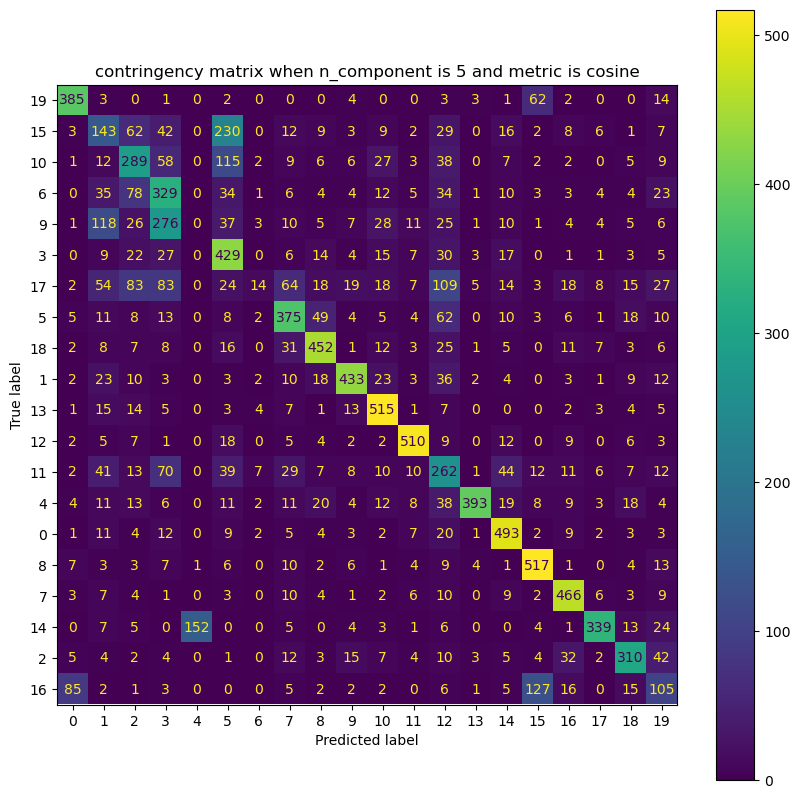

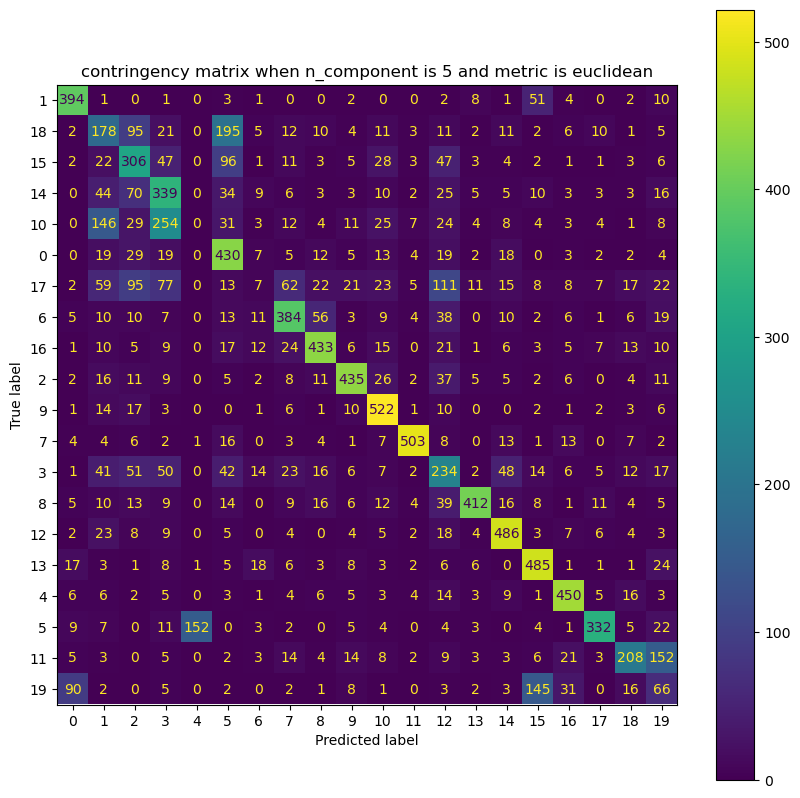

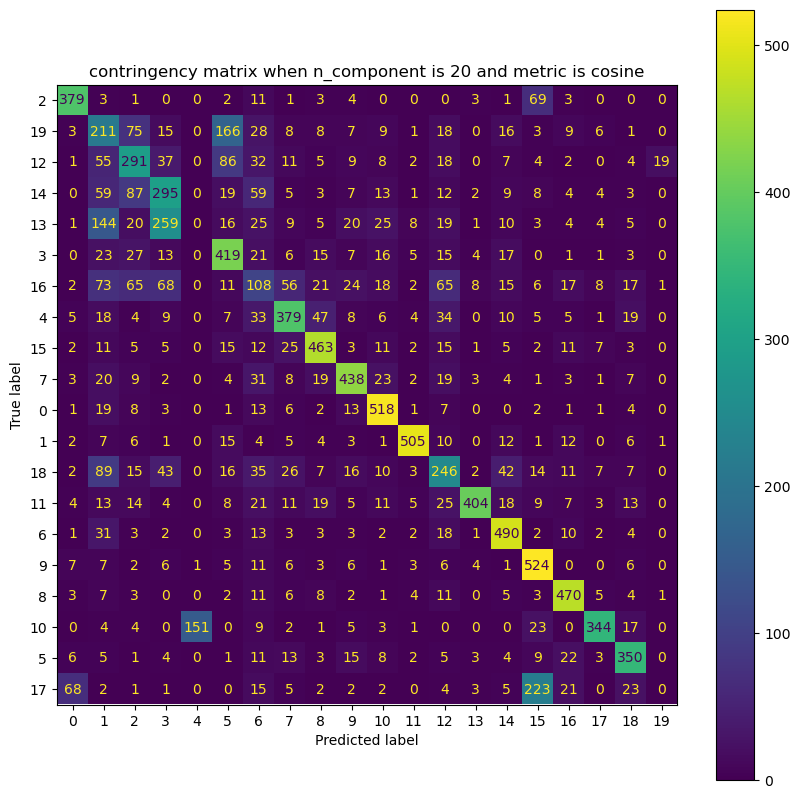

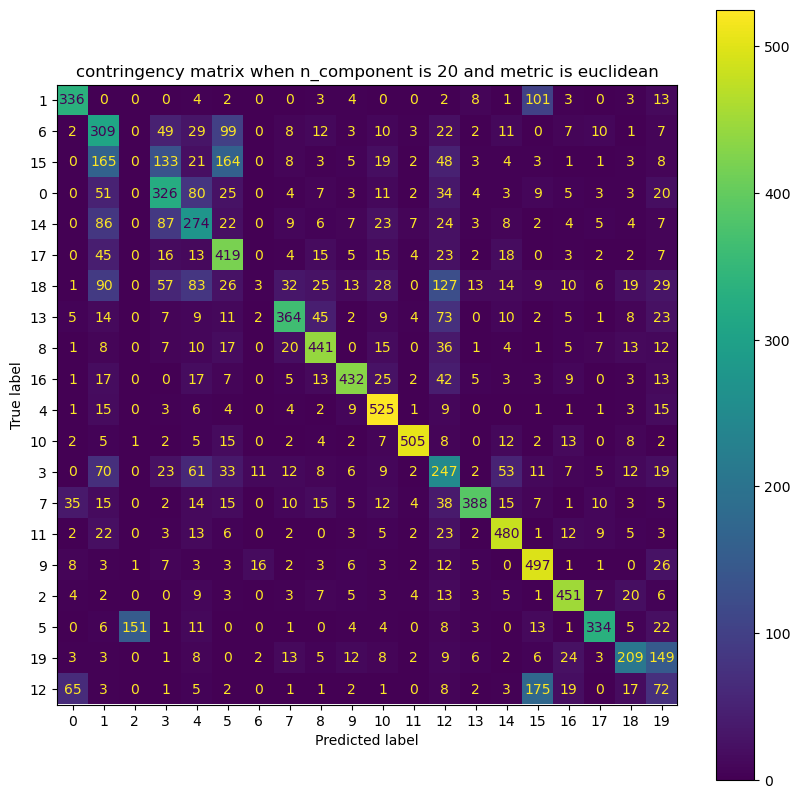

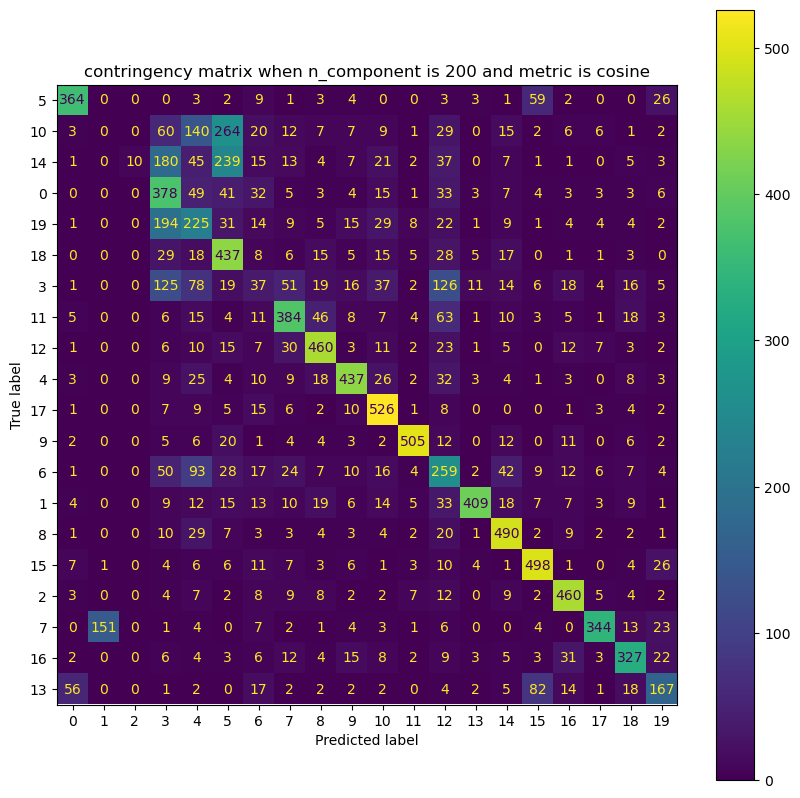

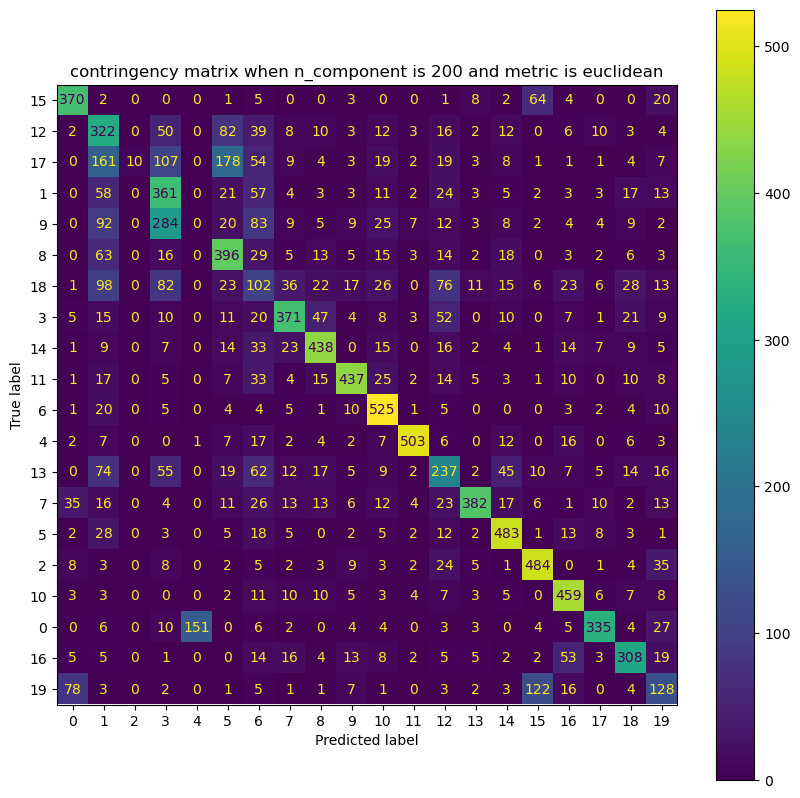

In [29]:
import umap
n_components_list = [5,20,200]
metric_list = ['cosine', 'euclidean']
for n_components in n_components_list:
    for metric in metric_list:
        X_reduced = umap.UMAP(random_state=42, n_components=n_components, 
                              metric=metric).fit_transform(X_tfidf_all)

        # perform clustering
        kmeans = KMeans(
        n_clusters=20,
        max_iter=1000,
        n_init=30,
        random_state=0,
        ).fit(X_reduced)

        # plot contingency matrix
        labels_pred = kmeans.labels_

        cm = confusion_matrix(labels_true, labels_pred)
        rows, cols = linear_sum_assignment(cm, maximize=True)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm[rows[:, np.newaxis], cols])
        disp.plot()
        fig, ax = plt.gcf(), plt.gca()
        fig.set_size_inches(10,10)
        ax.set_title(f"contringency matrix when n_component is {n_components} and metric is {metric}")
        ax.set_xticklabels(rows)
        ax.set_yticklabels(cols)


        # print the five clustering metrics for NMF
        print ('Report five clustering metrics when UMAP is used before clustering the 20 classes:\n')
        print (f"n_component is {n_components} and metric is {metric}\n")
        evaluate(kmeans, print_scores = True)

### QUESTION 12: 
- Analyze the contingency matrices. Which setting works best and why? What about for each metric choice?

Best setting is when 20 of the most informative components are retained and cosine is used a measure for distance. Among the options for n_components definitely 200 suffers from the curse of dimensionality and 5 suffers from carrying a small amount of information. The cosine metric is better than euclidean as it ignore the difference in the magnitude and just pay attention to the difference in the orientations.

### QUESTION 13: 
- So far, we have attempted K-Means clustering with 4 different representation learning techniques (sparse TF-IDF representation, PCA-reduced, NMF-reduced, UMAP-reduced). Compare and contrast the clustering results across the 4 choices, and suggest an approach that is best for the K-Means clustering task on the 20-class text data. Choose any choice of clustering metrics for your comparison.

Table below presents the performance of KMeans with different dimensioanlity redcution methods.
|                 | Homogeneity        | Completeness       | V-measure          |  Rand-Index         | mutual information |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
TF-IDF             | 0.24        | 0.33        | 0.28        | 0.17        | 0.28          |
PCA-reduced             | 0.34        | 0.38        | 0.36        | 0.13        | 0.36          |
NMF-reduced             | 0.30        | 0.33        | 0.32        | 0.11        | 0.31          |
UMAP-reduced             | 0.52       | 0.53        | 0.53        | 0.42        | 0.52          |

Based on all the five measures, UMAP with cosine metric and 20 retained components is the best choice of dimensionality reduction for KMeans.

## Agglomerative Clustering
### QUESTION 14: 

Use UMAP to reduce the dimensionality properly, and perform Agglom- erative clustering with n_clusters=20 . Compare the performance of “ward” and “single” linkage criteria.


Report five clustering metrics of Agglomerative clustering:

Linkage is ward and metric is euclidean

Homogeneity: 0.5132880860655622
Completeness: 0.5328737365154925
V-measure: 0.5228975755506509
Adjusted Rand-Index: 0.3939289274681139
Adjusted mutual information score: 0.5202468461999253


[[0.5132880860655622],
 [0.5328737365154925],
 [0.5228975755506509],
 [0.3939289274681139],
 [0.5202468461999253]]

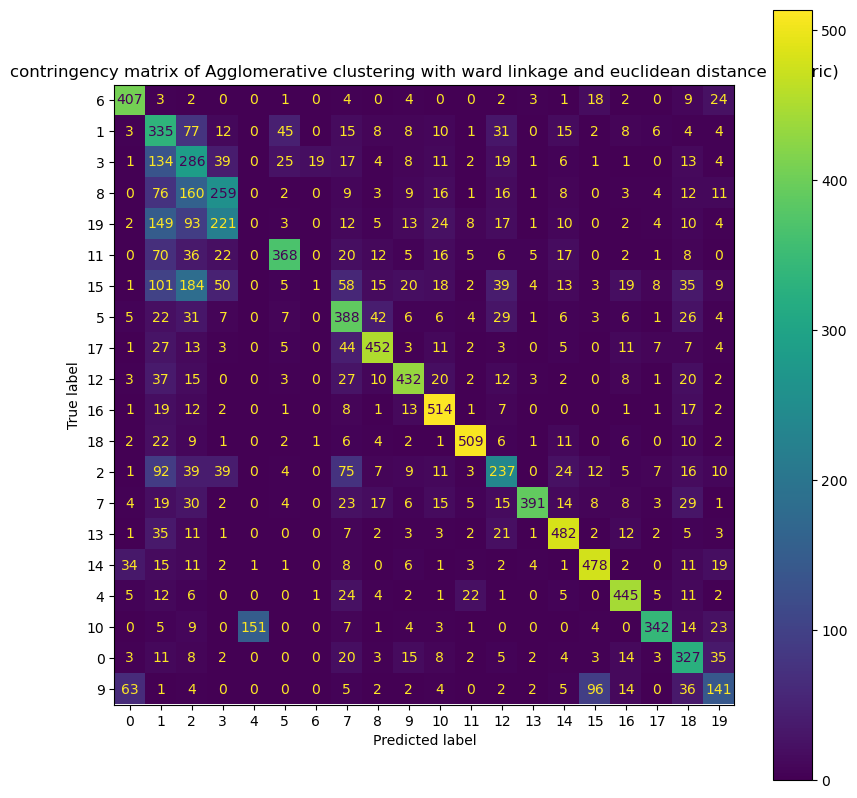

In [60]:
from sklearn.cluster  import AgglomerativeClustering

X_reduced = umap.UMAP(random_state=42, n_components=20, 
                              metric='cosine').fit_transform(X_tfidf_all)
linkage = 'ward'
metric = 'euclidean'
agg_clus = AgglomerativeClustering(n_clusters=20, metric=metric, linkage=linkage)
agg_clus.fit(X_reduced)

# plot contingency matrix
labels_pred = agg_clus.labels_

cm = confusion_matrix(labels_true, labels_pred)
rows, cols = linear_sum_assignment(cm, maximize=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm[rows[:, np.newaxis], cols])
disp.plot()
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(10,10)
ax.set_title(f"contringency matrix of Agglomerative clustering with {linkage} linkage and {metric} distance (metric)")
ax.set_xticklabels(rows)
ax.set_yticklabels(cols)


# print the five clustering metrics for NMF
print ('Report five clustering metrics of Agglomerative clustering:\n')
print (f"Linkage is {linkage} and metric is {metric}\n")
evaluate(agg_clus, print_scores = True)

Report five clustering metrics of Agglomerative clustering:

Linkage is single and metric is cosine

Homogeneity: 0.058171930036078824
Completeness: 0.47284355222376045
V-measure: 0.10359856899431075
Adjusted Rand-Index: 0.00660265613521392
Adjusted mutual information score: 0.09633066395460368


[[0.058171930036078824],
 [0.47284355222376045],
 [0.10359856899431075],
 [0.00660265613521392],
 [0.09633066395460368]]

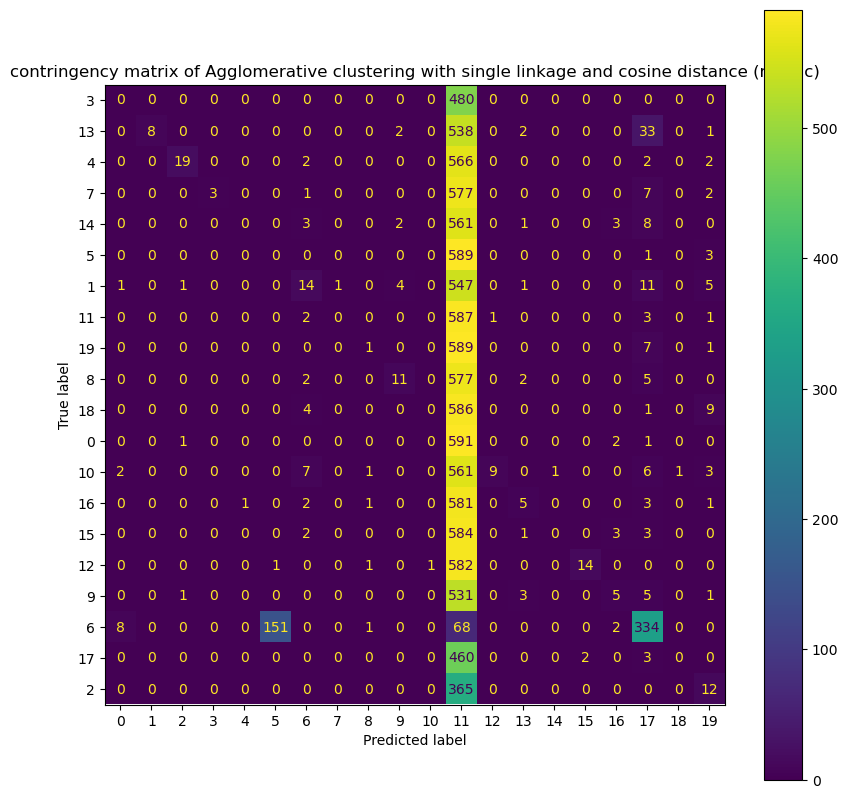

In [62]:
from sklearn.cluster  import AgglomerativeClustering

X_reduced = umap.UMAP(random_state=42, n_components=20, 
                              metric='cosine').fit_transform(X_tfidf_all)
linkage = 'single'
metric = 'cosine'
agg_clus = AgglomerativeClustering(n_clusters=20, metric=metric, linkage=linkage)
agg_clus.fit(X_reduced)

# plot contingency matrix
labels_pred = agg_clus.labels_

cm = confusion_matrix(labels_true, labels_pred)
rows, cols = linear_sum_assignment(cm, maximize=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm[rows[:, np.newaxis], cols])
disp.plot()
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(10,10)
ax.set_title(f"contringency matrix of Agglomerative clustering with {linkage} linkage and {metric} distance (metric)")
ax.set_xticklabels(rows)
ax.set_yticklabels(cols)


# print the five clustering metrics for NMF
print ('Report five clustering metrics of Agglomerative clustering:\n')
print (f"Linkage is {linkage} and metric is {metric}\n")
evaluate(agg_clus, print_scores = True)

Report five clustering metrics of Agglomerative clustering:

Linkage is single and metric is euclidean

Homogeneity: 0.05788471966940207
Completeness: 0.4676193829518471
V-measure: 0.10301733805361132
Adjusted Rand-Index: 0.006564776869762599
Adjusted mutual information score: 0.09573472274268574


[[0.05788471966940207],
 [0.4676193829518471],
 [0.10301733805361132],
 [0.006564776869762599],
 [0.09573472274268574]]

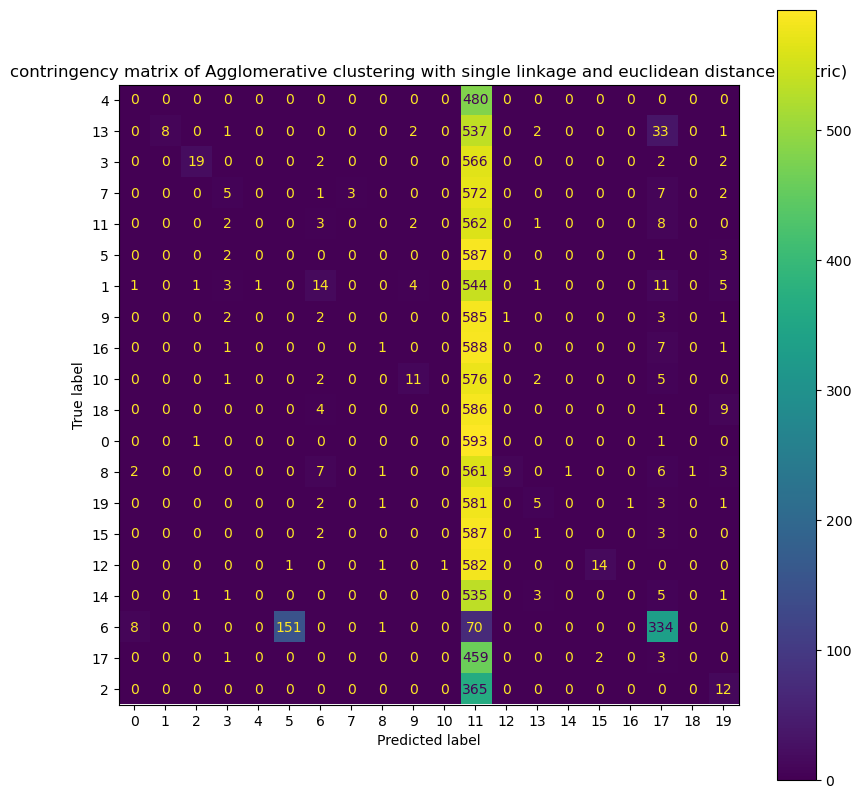

In [102]:
from sklearn.cluster  import AgglomerativeClustering

# X_reduced = umap.UMAP(random_state=42, n_components=20, 
#                               metric='cosine').fit_transform(X_tfidf_all)
linkage = 'single'
metric = 'euclidean'
agg_clus = AgglomerativeClustering(n_clusters=20, metric=metric, linkage=linkage)
agg_clus.fit(X_reduced)

# plot contingency matrix
labels_pred = agg_clus.labels_

cm = confusion_matrix(labels_true, labels_pred)
rows, cols = linear_sum_assignment(cm, maximize=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm[rows[:, np.newaxis], cols])
disp.plot()
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(10,10)
ax.set_title(f"contringency matrix of Agglomerative clustering with {linkage} linkage and {metric} distance (metric)")
ax.set_xticklabels(rows)
ax.set_yticklabels(cols)


# print the five clustering metrics for NMF
print ('Report five clustering metrics of Agglomerative clustering:\n')
print (f"Linkage is {linkage} and metric is {metric}\n")
evaluate(agg_clus, print_scores = True)

As reported above the 'ward' linkage outperforms 'single' linkage according to all 5 measures and the contingency matrix.

|                 | Homogeneity        | Completeness       | V-measure          |  Rand-Index         | mutual information |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
ward             | 0.51        | 0.53        | 0.52        | 0.39        | 0.52          |
single + cosine             | 0.06        | 0.47        | 0.10        | 0.01        | 0.10          |
single + euclidean             | 0.06        | 0.46        | 0.10        | 0.01        | 0.10          |

## HDBSCAN
### QUESTION 15

In [77]:
from sklearn.cluster  import HDBSCAN
        
X_reduced = umap.UMAP(random_state=42, n_components=20, 
                      metric='cosine').fit_transform(X_tfidf_all)

min_cluster_sizes = [20,100,200]
for min_cluster_size in min_cluster_sizes: 
    hdb_clus = HDBSCAN(min_cluster_size=min_cluster_size,  min_samples=300, cluster_selection_epsilon=0.3)
    hdb_clus.fit(X_reduced)
    
    # print the five clustering metrics for NMF
    print ('\n Report five clustering metrics of HDBSCAN clustering:\n')
    print (f"min_cluster_size={min_cluster_size} \n")
    evaluate(hdb_clus, print_scores = True)


 Report five clustering metrics of HDBSCAN clustering:

min_cluster_size=20 

Homogeneity: 0.3286946622869506
Completeness: 0.5705936702021223
V-measure: 0.4171100345782306
Adjusted Rand-Index: 0.1259141419700349
Adjusted mutual information score: 0.4154283236369532

 Report five clustering metrics of HDBSCAN clustering:

min_cluster_size=100 

Homogeneity: 0.35226711246359066
Completeness: 0.6034750934519908
V-measure: 0.44485725815650634
Adjusted Rand-Index: 0.11509533170105717
Adjusted mutual information score: 0.4430637091524201

 Report five clustering metrics of HDBSCAN clustering:

min_cluster_size=200 

Homogeneity: 0.044042825382197094
Completeness: 0.31279977502810424
V-measure: 0.0772137959723019
Adjusted Rand-Index: 0.007574573907704037
Adjusted mutual information score: 0.07629798352469327


According to the evaluation metrics, min_cluster_size of 100 has the best performance.
### Question 16

In [72]:
def evaluate_hdbscan(labels_pred, labels_true, print_scores = False):
    scores = defaultdict(list)
    scores["Homogeneity"].append(metrics.homogeneity_score(labels_true, labels_pred))
    scores["Completeness"].append(metrics.completeness_score(labels_true, labels_pred))
    scores["V-measure"].append(metrics.v_measure_score(labels_true, labels_pred))
    scores["Adjusted Rand-Index"].append(
        metrics.adjusted_rand_score(labels_true, labels_pred)
    )
    scores["Adjusted mutual information score"].append(
        metrics.adjusted_mutual_info_score(labels_true, labels_pred)
    )
    score_list = [scores["Homogeneity"], scores["Completeness"], scores["V-measure"]
                 ,scores["Adjusted Rand-Index"], scores["Adjusted mutual information score"]]
    if print_scores:
        for score_name, score_values in scores.items():
            print (f"{score_name}: {score_values[0]}")
    
    return score_list
        

In [75]:
unique_labels, category_sizes = np.unique(labels_true, return_counts=True)
print (category_sizes)

[480 584 591 590 578 593 585 594 598 597 600 595 591 594 593 599 546 564
 465 377]


Estimated number of clusters: 9
Estimated number of noise points: 5520

 Report five clustering metrics of HDBSCAN clustering:

min_cluster_size=20 

Homogeneity: 0.6169771795322188
Completeness: 0.8517589268398972
V-measure: 0.7156027798909788
Adjusted Rand-Index: 0.53280823197834
Adjusted mutual information score: 0.7140408523057398


[[0.6169771795322188],
 [0.8517589268398972],
 [0.7156027798909788],
 [0.53280823197834],
 [0.7140408523057398]]

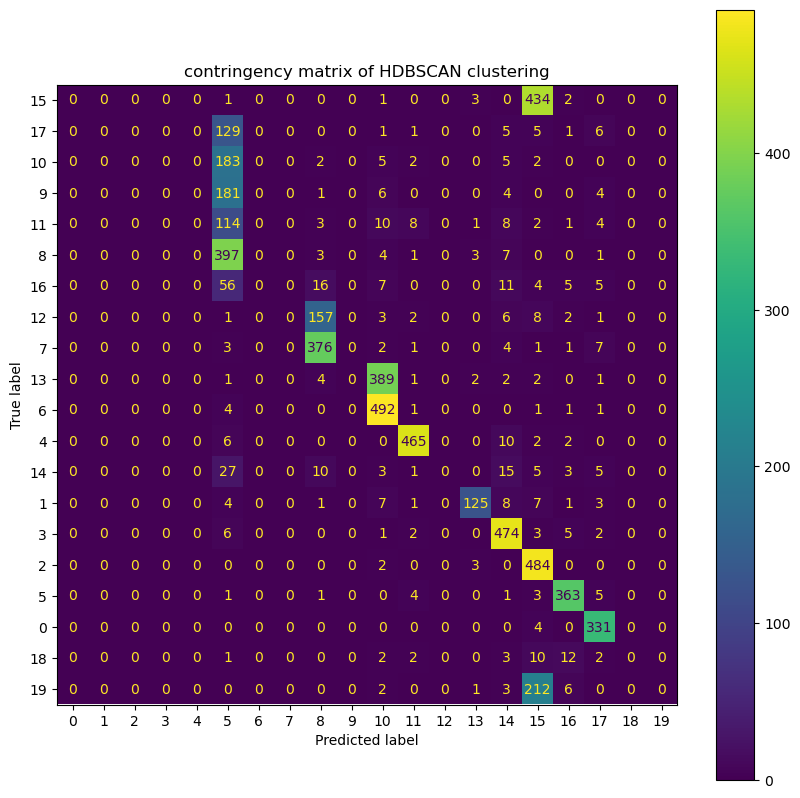

In [100]:
# X_reduced = umap.UMAP(random_state=42, n_components=20, 
#                               metric='cosine').fit_transform(X_tfidf_all)

hdb_clus = HDBSCAN(min_cluster_size=100,  min_samples=300, cluster_selection_epsilon=0.3)
hdb_clus.fit(X_reduced)

# plot contingency matrix
labels_pred = hdb_clus.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_pred)) - (1 if -1 in labels_pred else 0)
n_noise_ = list(labels_pred).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


# Filter out noise points (labels_pred == -1)
valid_indices = labels_pred != -1
filtered_labels_true = labels_true[valid_indices]
filtered_labels_pred = labels_pred[valid_indices]

cm = confusion_matrix(filtered_labels_true, filtered_labels_pred)
rows, cols = linear_sum_assignment(cm, maximize=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm[rows[:, np.newaxis], cols])
disp.plot()
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(10,10)
ax.set_title(f"contringency matrix of HDBSCAN clustering")
ax.set_xticklabels(rows)
ax.set_yticklabels(cols)

# print the five clustering metrics for NMF
print ('\n Report five clustering metrics of HDBSCAN clustering:\n')
print (f"min_cluster_size=20 \n")
evaluate_hdbscan(filtered_labels_pred, filtered_labels_true, print_scores = True)



Model has found 9 clusters. There are 5520 examples which are identified as Noisy samples and are given the label -1 (all data consists of 11314 examples). Here, the performance metrics are computed after removing these noisy samples, which forms more than 40% of the data. Therefore, metrics have been improved with respect to the results from previous cell. For instance, Homogeneity is now 0.61 and Completeness is 0.85 

### QUESTION 17: 
- <font color='red'>Based on your experiments, which dimensionality reduction technique and clustering methods worked best together for 20-class text data and why? 

Although HDBSCAN achieve high performance scores, it has shortcoming in selecting correct number of clusters.
UMAP dimensionality reduction with 20 number of kept components and cosine as difference measure together with KMeans lead to best clustering method for this dataset.


